Import data from previous notebook and librairies

In [70]:
import pandas as pd
import shap
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time

%matplotlib inline
shap.initjs()

pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('X_clean.csv')
data_energystar = pd.read_csv('X_clean_with_energystar.csv')

data.head()


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,Latitude,Longitude,RatioElectricityUse,RatioNaturalGasUse,...,Residential Care Facility,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Worship Facility
0,249.980000,7226362.500000,1.000000,12,88434,97,47.612200,-122.337990,0.160041,0.001766,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,295.860000,8387933.000000,1.000000,11,88502,28,47.613170,-122.333930,0.113309,0.006134,...,0.000000,4622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2089.280000,72587024.000000,1.000000,41,759392,55,47.613930,-122.338100,0.199973,0.000206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,286.430000,6794584.000000,1.000000,10,61320,98,47.614120,-122.336640,0.119437,0.002666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,505.010000,14172606.000000,1.000000,18,113580,44,47.613750,-122.340470,0.111020,0.006212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Creation of class Data, where it setup all model, and have a public method run to benchmark differents model with the datasett using Kfold to try different setup of tain/test data.
All model use CV to setup best hyperparameters.
Here we do an export to make a test in next notebook.

In [87]:
class SHAPAnalyzer:
    def __init__(self, model, X_train, X_test, mode, name):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.mode = mode
        print(name)
    
    def calculate_and_plot_shap_global(self):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values, self.X_train)
        return shap_values
    
    def calculate_and_plot_shap_local(self, instance_index=0, decimal_places=2):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)

        shap_values = explainer(self.X_test)
        shap_values_instance = shap_values[instance_index]
        shap_values_instance.values = np.round(shap_values_instance.values, decimal_places)
        feature_names = [f"{name} = {round(value, decimal_places)}" 
                         for name, value in zip(self.X_test.columns, self.X_test.iloc[instance_index])]

        shap.force_plot(
            explainer.expected_value,
            shap_values_instance.values,
            feature_names,
            matplotlib=True
        )
        return shap_values_instance


In [58]:
def show_result(res):
    list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
    res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

    scores_r2 = res[list_r2].mean().reset_index()
    print(scores_r2)
    scores_r2.columns = ['Model', 'Mean R²']
    sns.barplot(x='Model', y='Mean R²', data=scores_r2)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [59]:
def show_time(res):
    time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
    print(time)
    time.columns = ['Model', 'Mean Time']
    sns.barplot(x='Model', y='Mean Time', data=time)
    plt.xticks(rotation=45, ha='right')
    plt.show()

In [90]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.n_jobs = 10
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'random forest R2': [],
            'xgboost R2': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.name_list = ['linear', 'ridge', 'lasso', 'elastic', 'random forest', 'xgboost']
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self, train, test):
        scaler = StandardScaler()
        df_train = pd.DataFrame(scaler.fit_transform(train), columns=self.data.columns)
        df_test = pd.DataFrame(scaler.transform(test), columns=self.data.columns)
        return df_train, df_test
           
    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        self.models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                self.X_train, self.X_test = self.preprocess(self.X_train, self.X_test)
                self.models[0] = self.linear_regression(self.models[0])
                pbar.update(1)
                self.models[1] = self.ridge_regression(self.models[1])
                pbar.update(1)
                self.models[2] = self.lasso_regression(self.models[2])
                pbar.update(1)
                self.models[3] = self.elastic_net(self.models[3])
                pbar.update(1)
                self.models[4] = self.random_forest_regression(self.models[4])
                pbar.update(1)
                self.models[5] = self.xgboost_regression(self.models[5])
                pbar.update(1)
            for i in range(len(self.models)):
                explainer = SHAPAnalyzer(self.models[i], self.X_train, self.X_test, i, self.name_list[i])
                explainer.calculate_and_plot_shap_global()
                explainer.calculate_and_plot_shap_local()
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        explainer = shap.Explainer(model, self.X_train)
        shap_values = explainer(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        shap.plots.force(shap_values[0])
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

Transorme the result from the class method run to dataframe to use it later and run the tests

Prediction SiteEnergyUse(kBtu)


Epoch Progress:  20%|██        | 6/30 [00:25<02:38,  6.60s/it]

linear


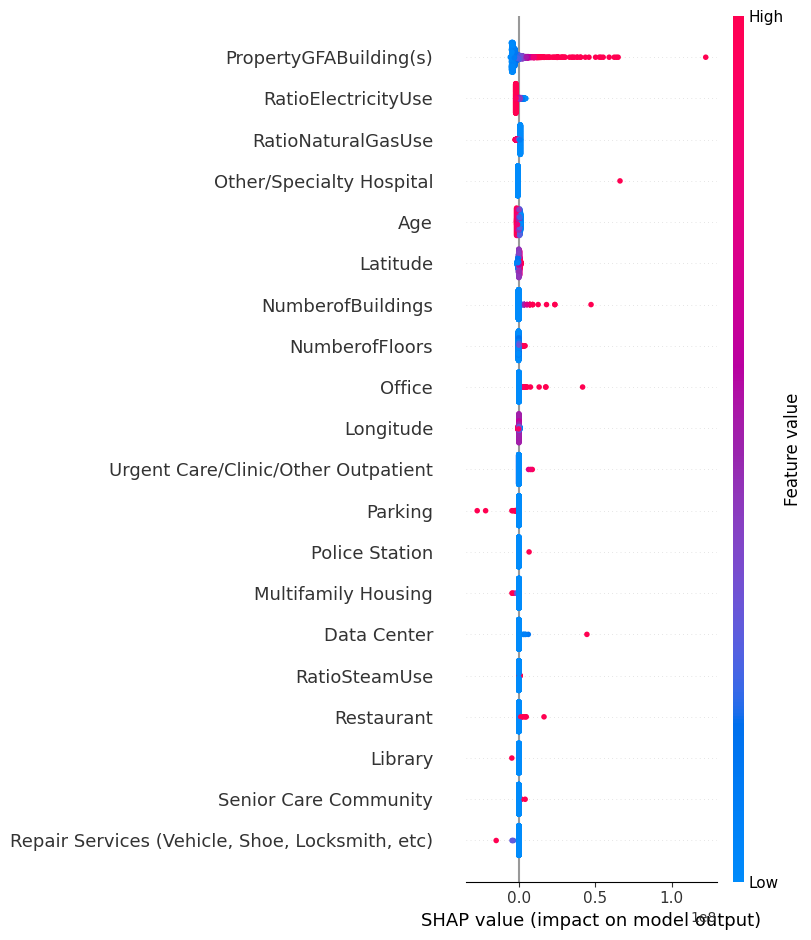

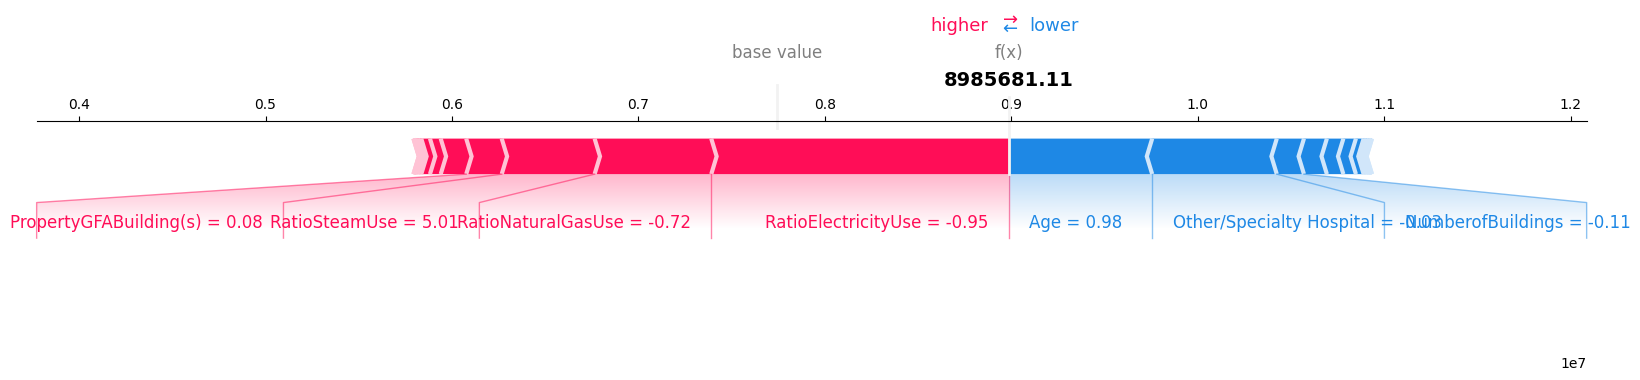

ridge


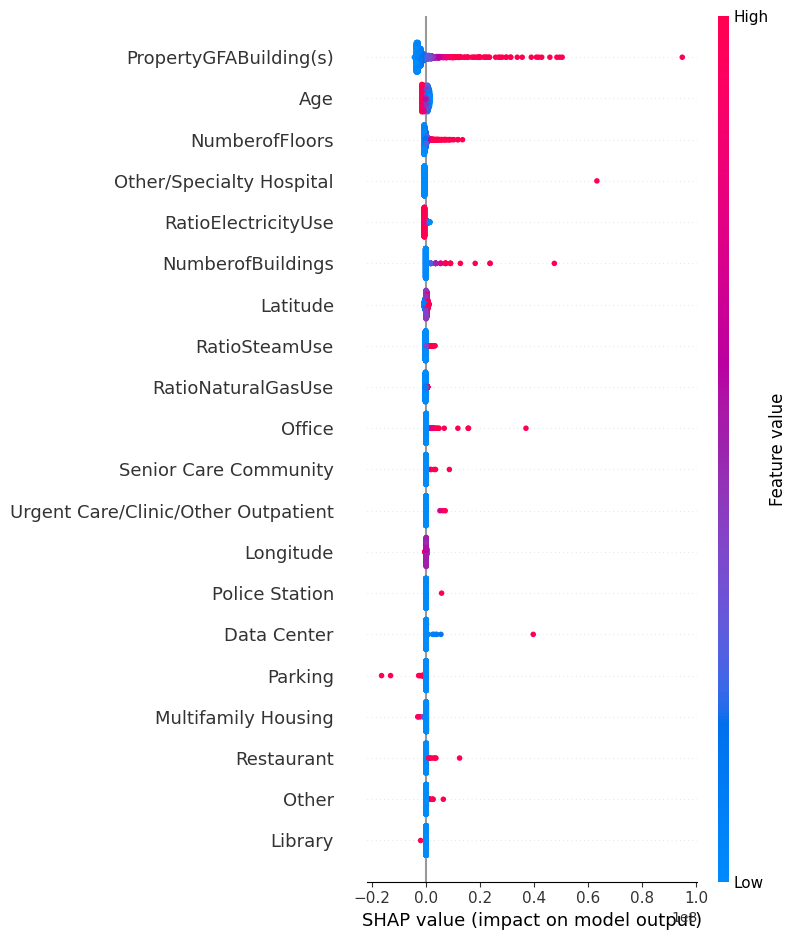

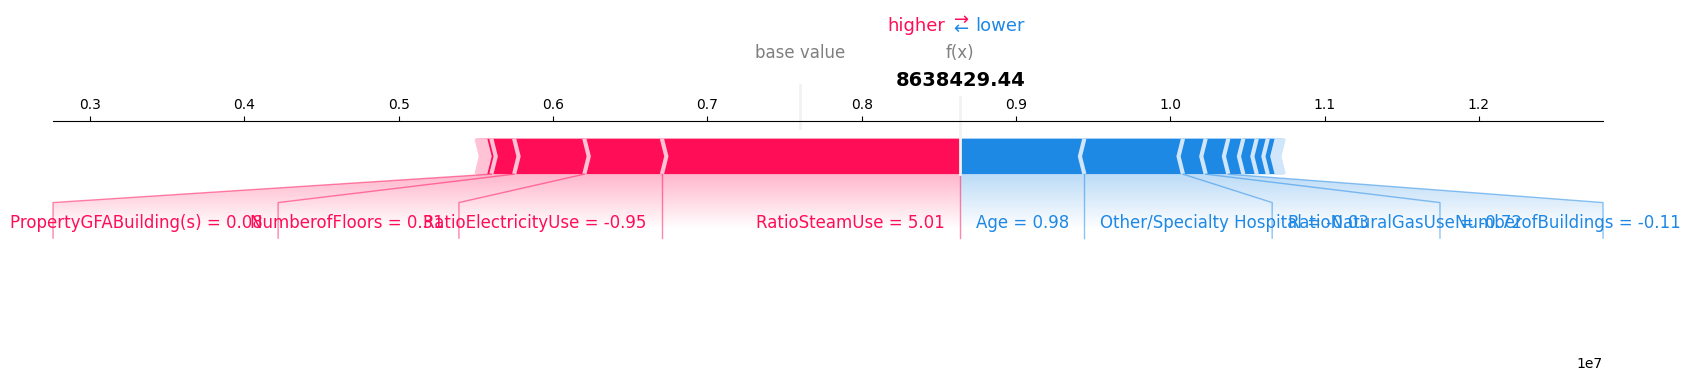

lasso


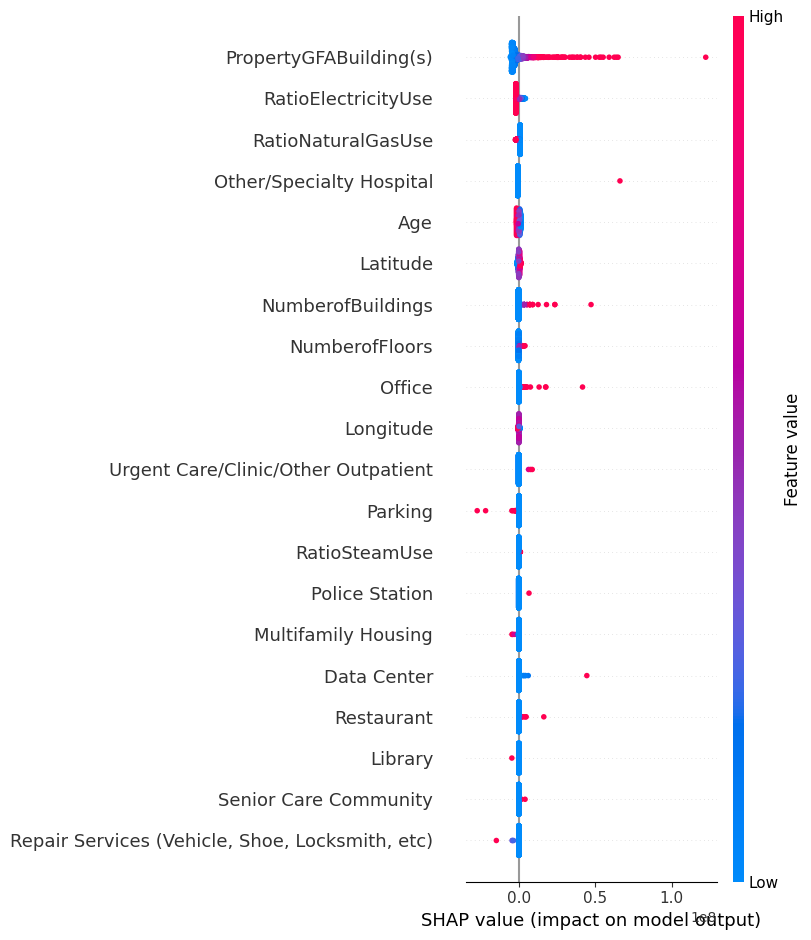

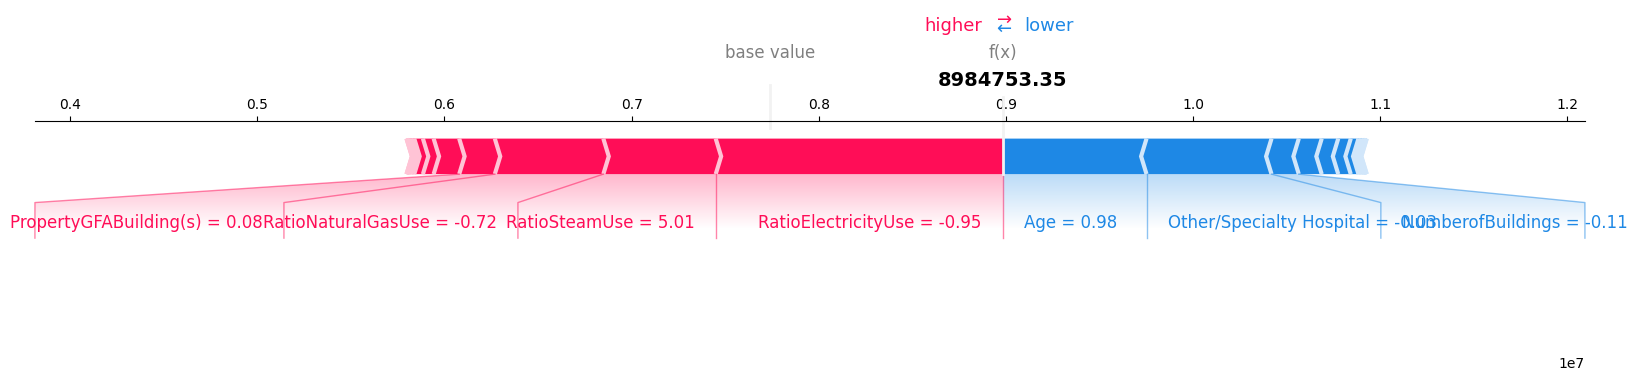

elastic


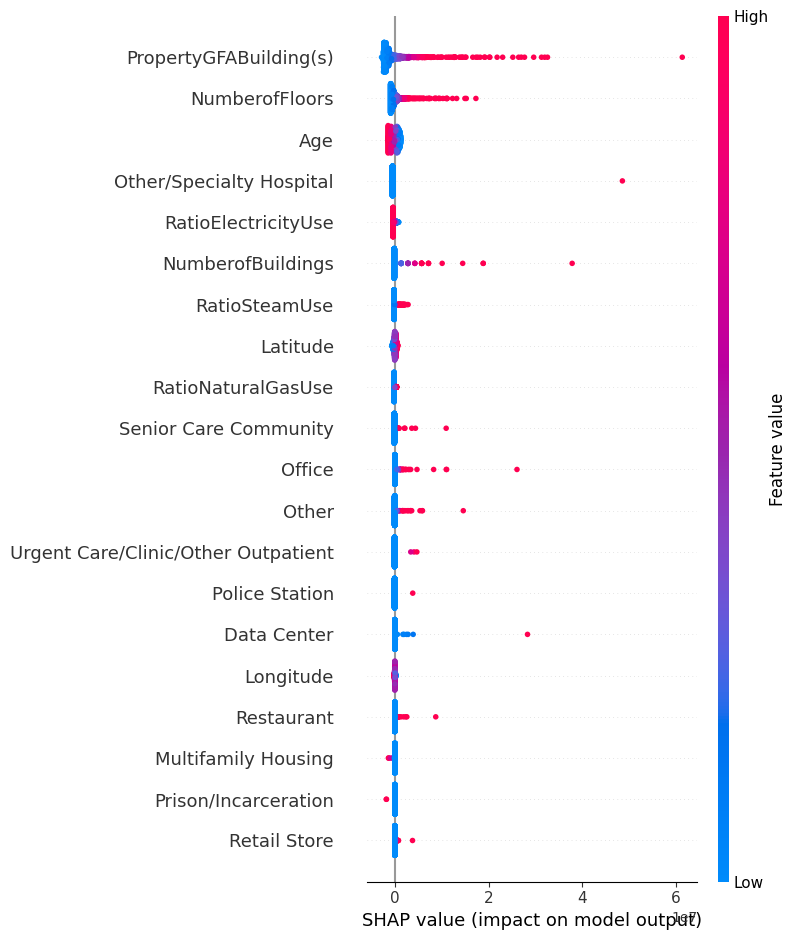

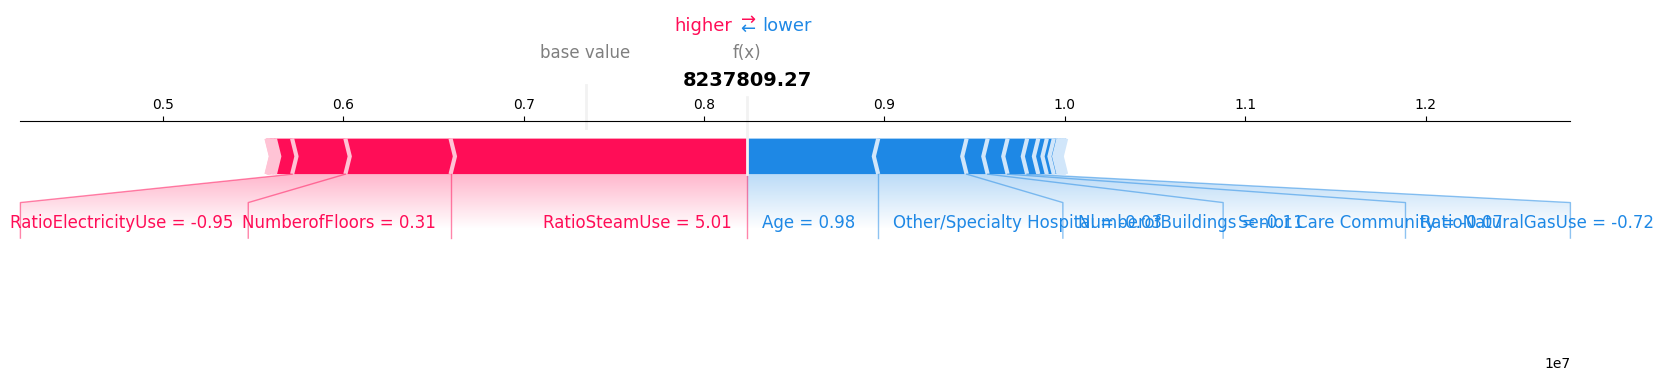

random forest


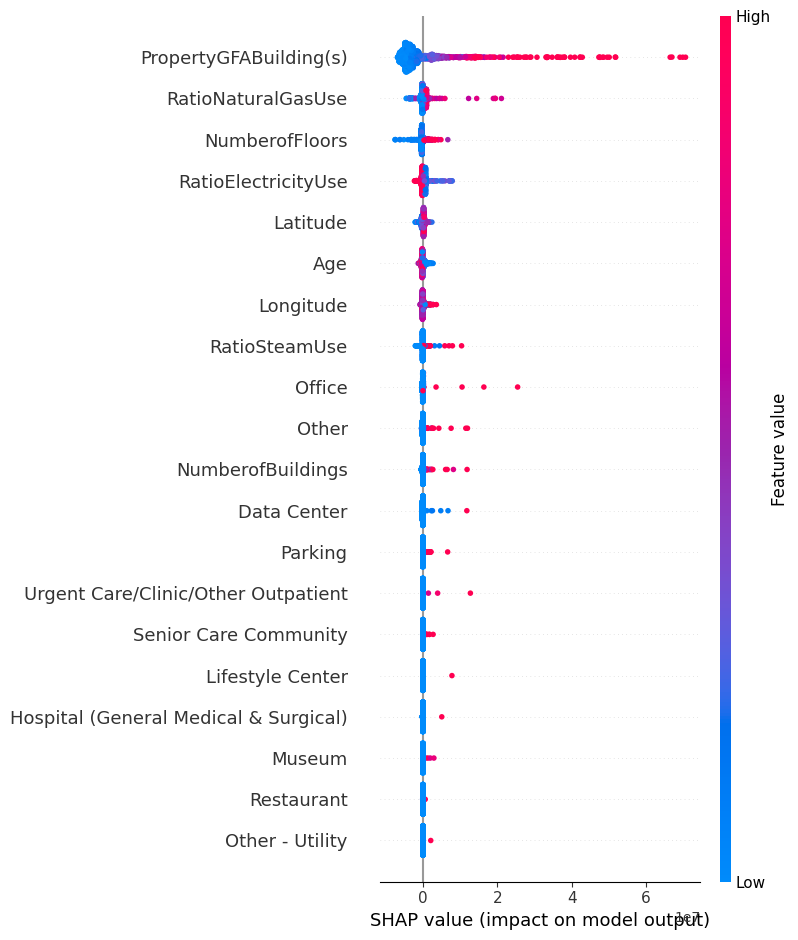

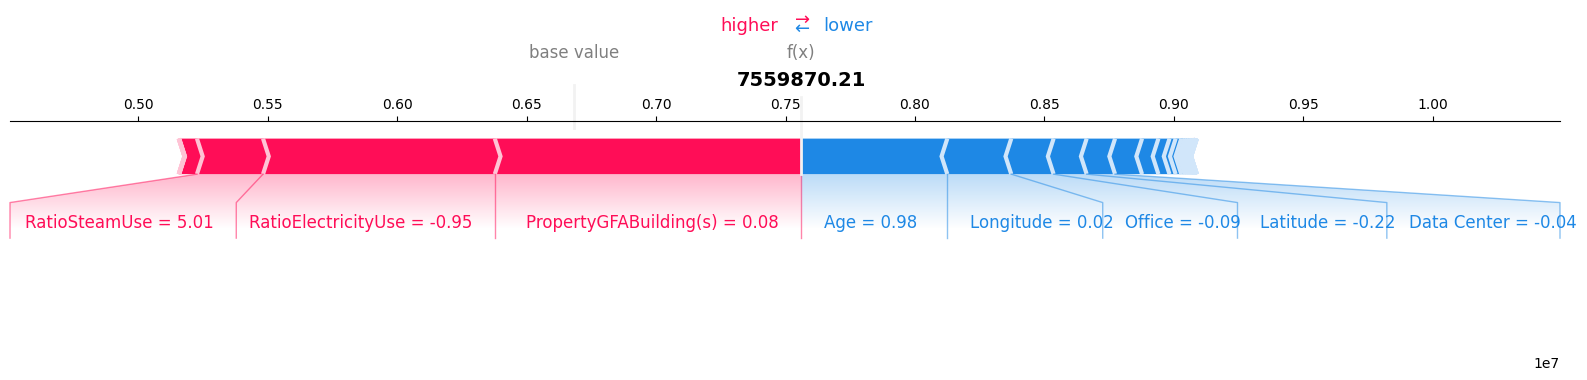

xgboost


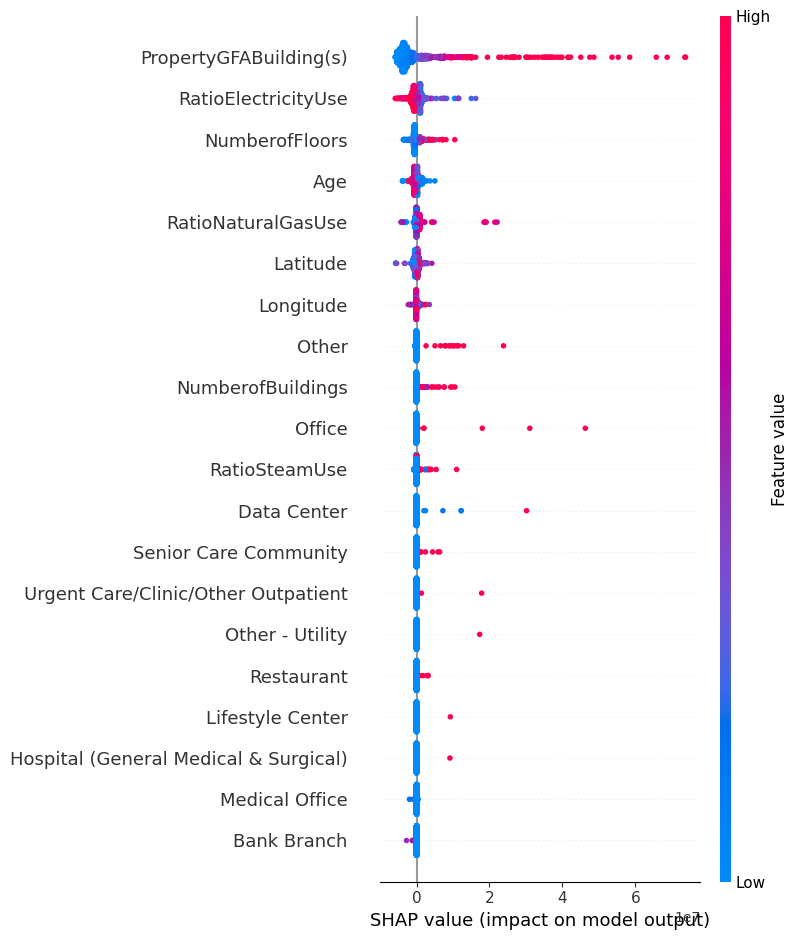

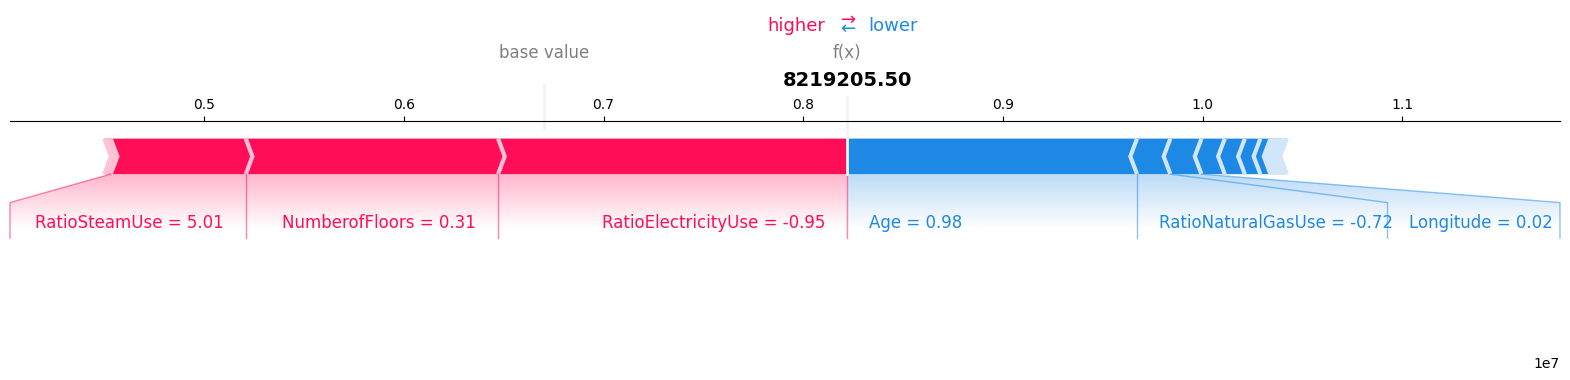

Epoch Progress:  20%|██        | 6/30 [00:38<02:35,  6.47s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-489052808808258336669992747008.000000,0.643336,0.594625,0.632122,0.606590,0.625099,190.006819,997.108343,8.003168,0.916360,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.5792283882759269, 'learning_rate':...",0.070139,0.222938,0.514018,0.220297,16.989863,7.641611


In [89]:
import time
df = Data(data, 1)

res = pd.DataFrame(df.run())
res.head()

Calculation of means to compare all model and visualisation - R2

              index         0
0         linear R2 -0.405643
1          ridge R2  0.536312
2          lasso R2  0.511250
3        elastic R2  0.283567
4  random forest R2  0.638765
5        xgboost R2  0.631661


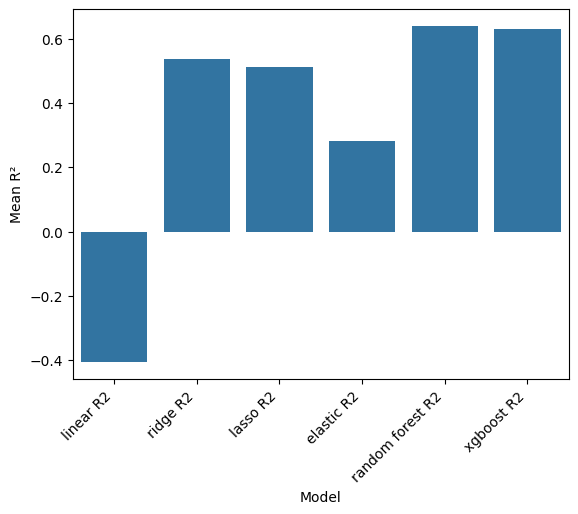

In [32]:
show_result(res)

xgboost have the best score but Random forest and ridge are very close

Calculation of means to compare all model and visualisation - time

                index         0
0         linear time  0.228378
1          ridge time  0.295972
2          lasso time  1.017276
3        elastic time  0.346635
4  random forest time 15.768264
5        xgboost time  7.169351


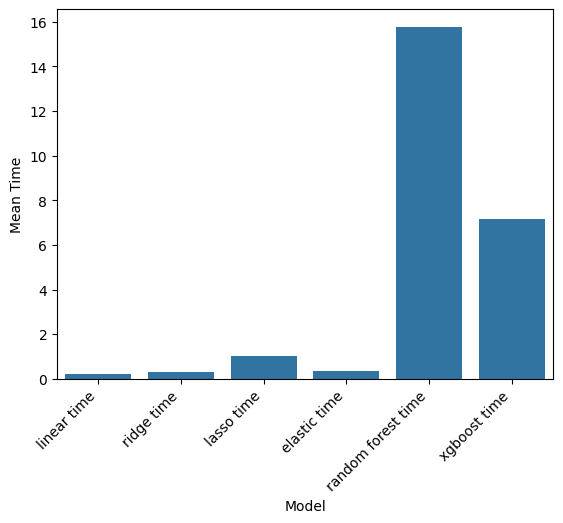

In [33]:
show_time(res)

random forest is bit lower in R2 but have a realy biger time consuming, Xgboost will be the faster

Prediction TotalGHGEmissions


Epoch Progress: 100%|██████████| 30/30 [02:10<00:00,  6.78s/it]

linear


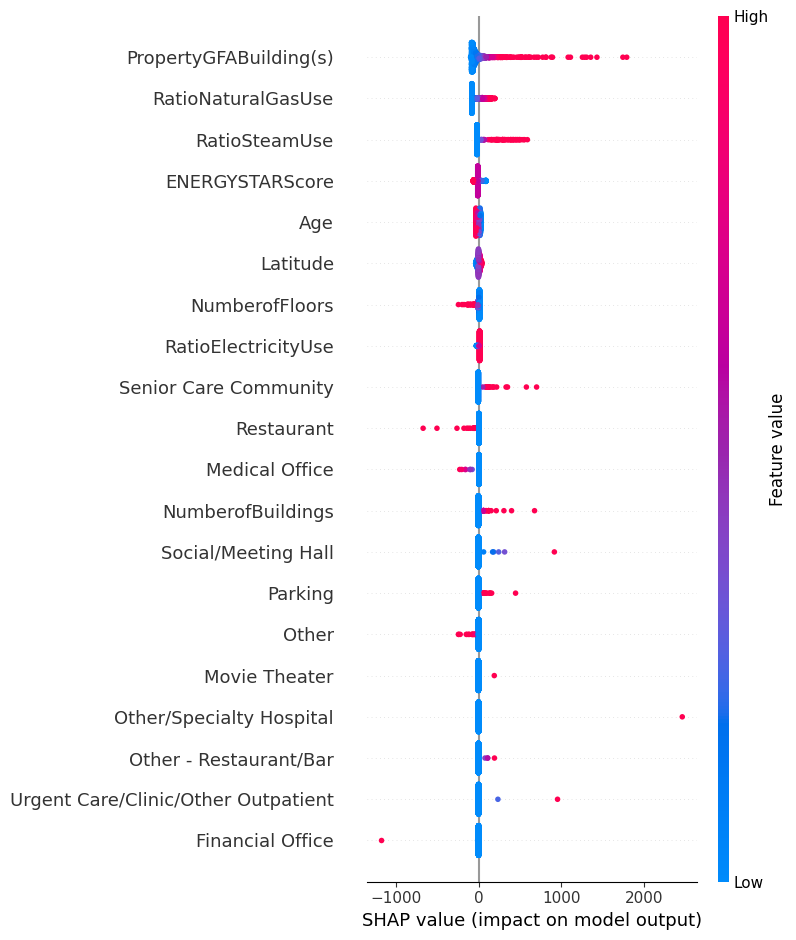

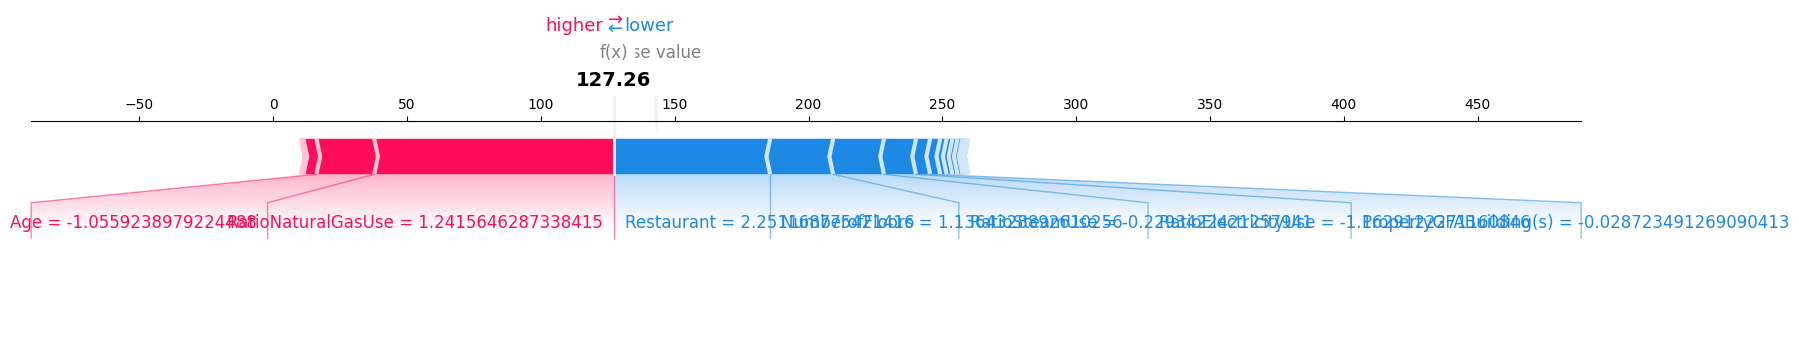

ridge


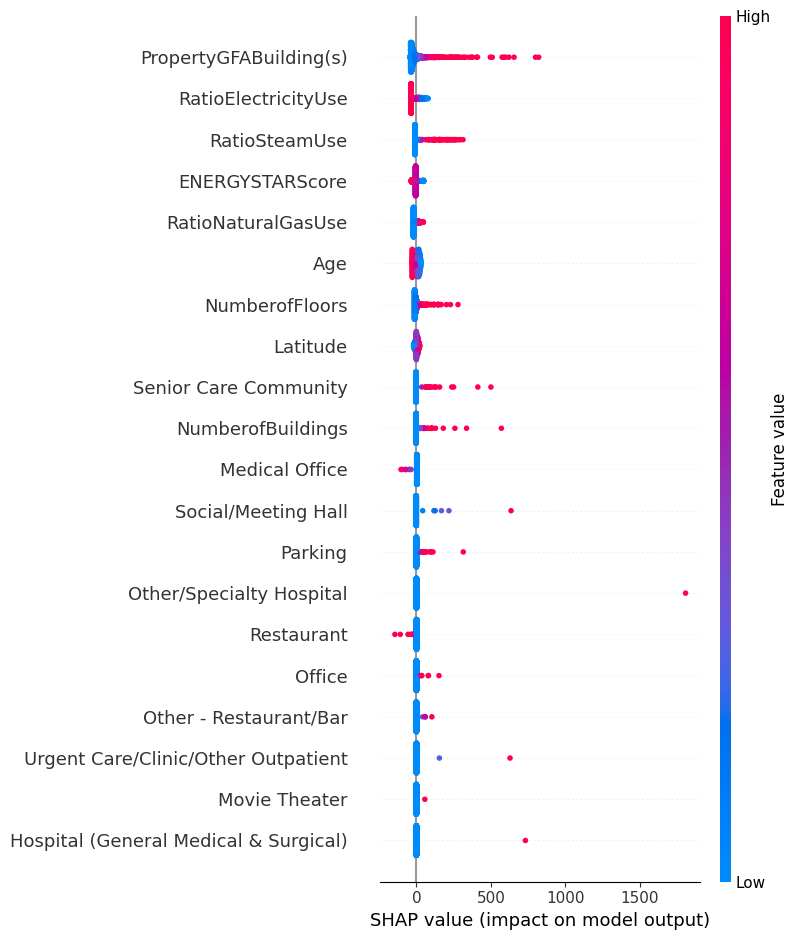

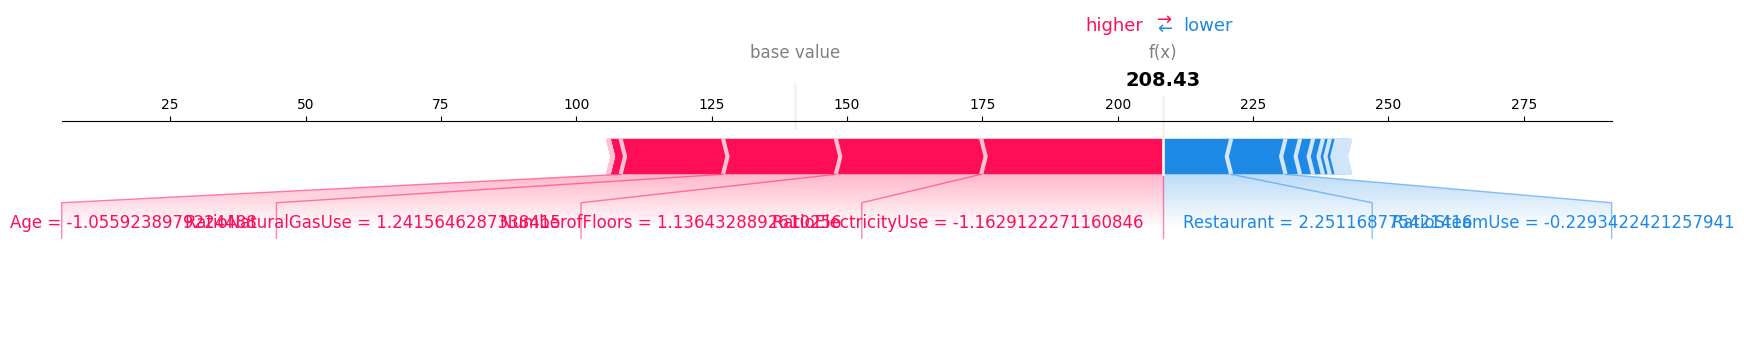

lasso


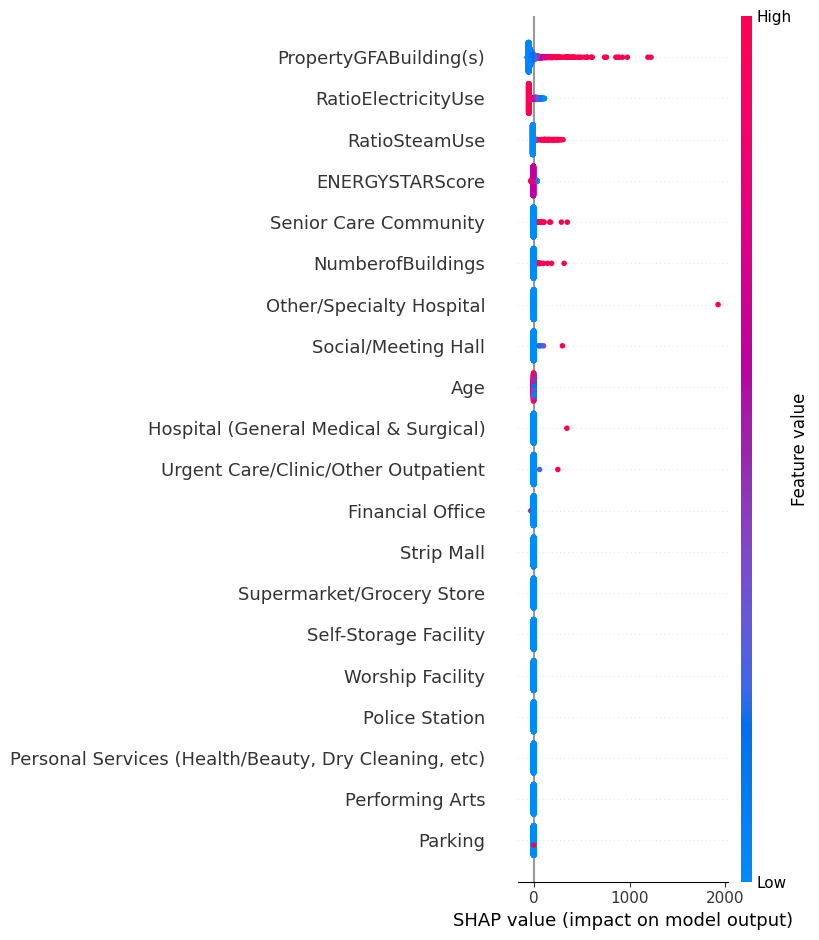

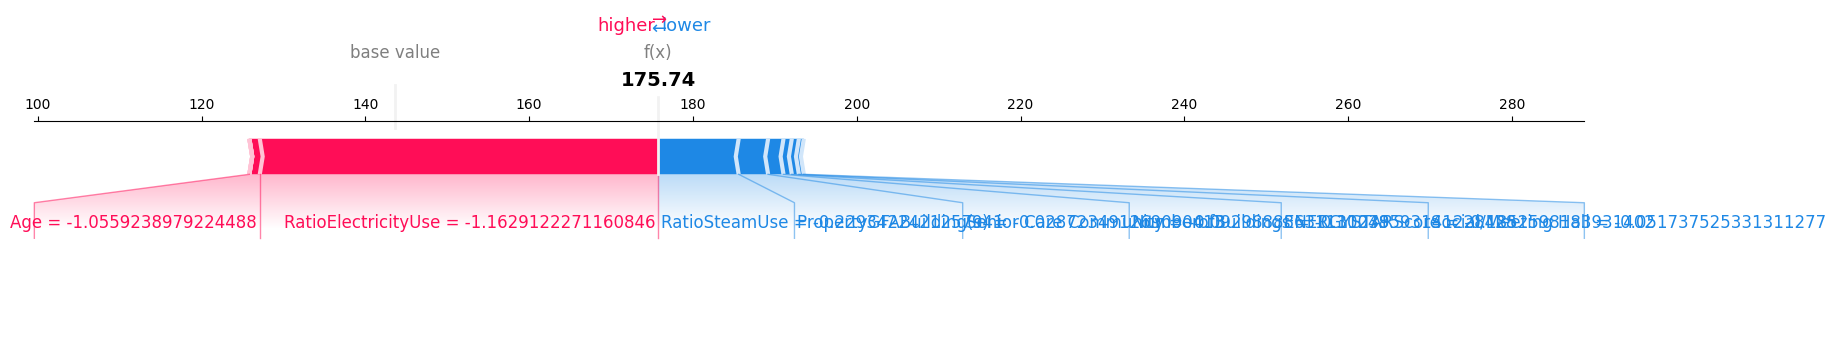

elastic


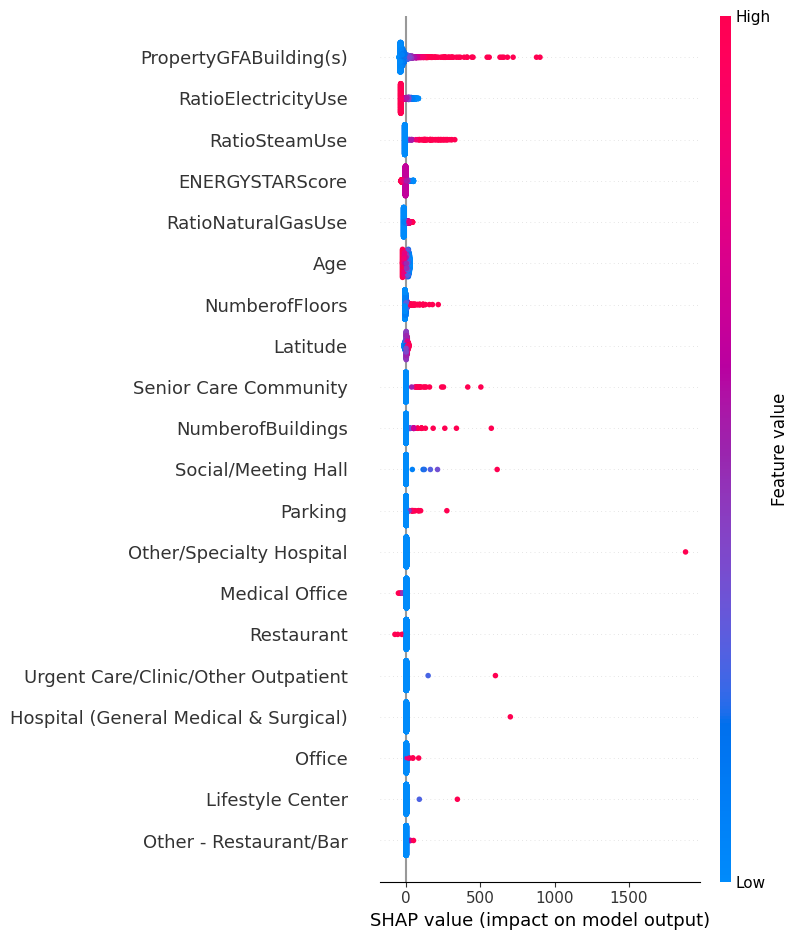

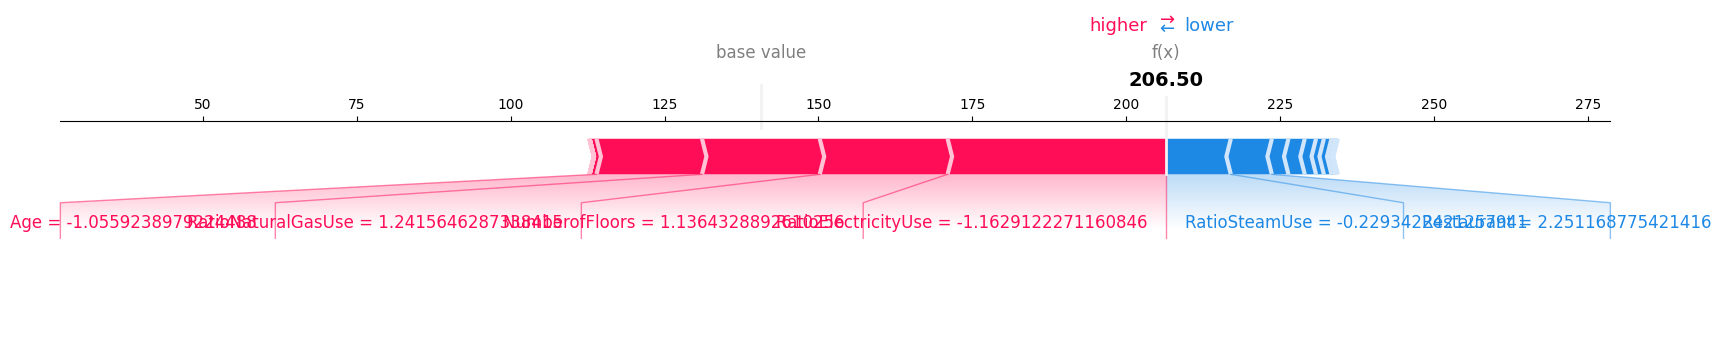

random forest


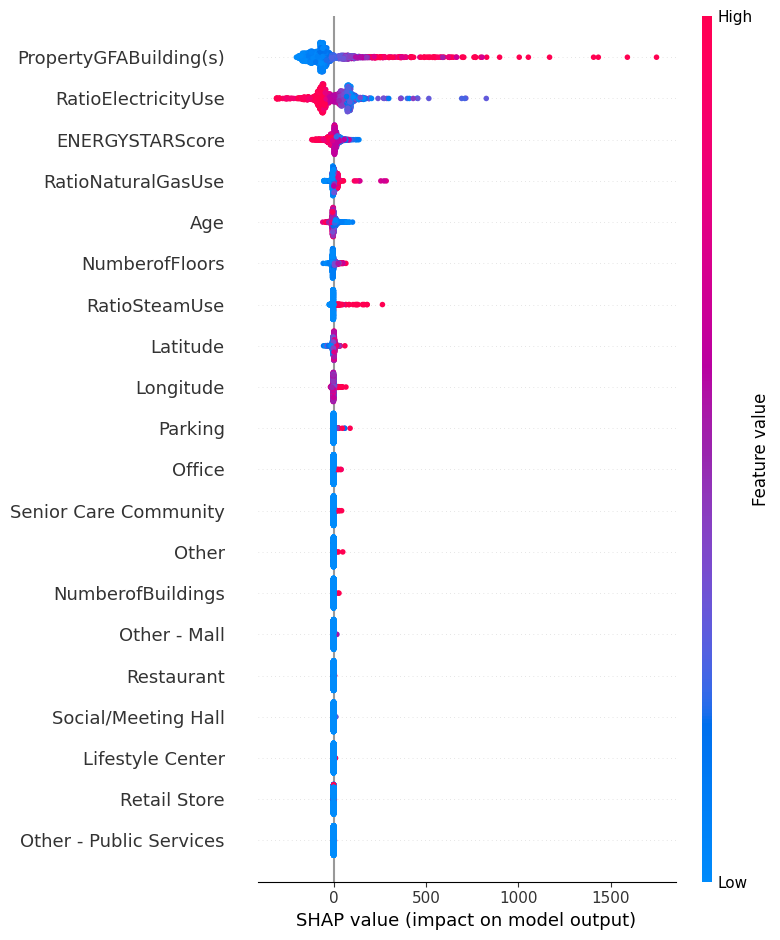

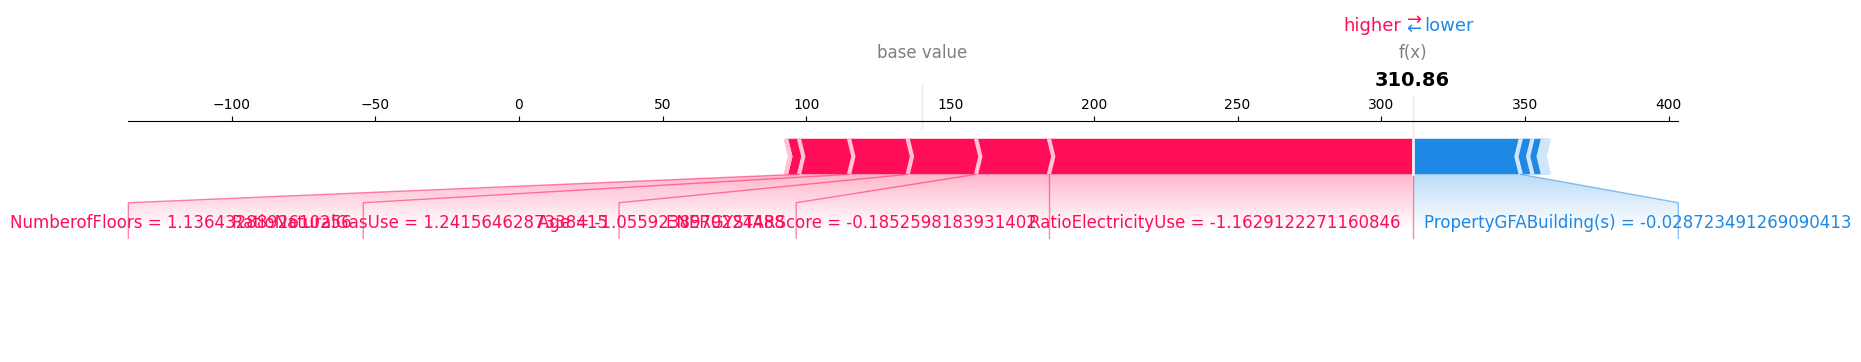

xgboost


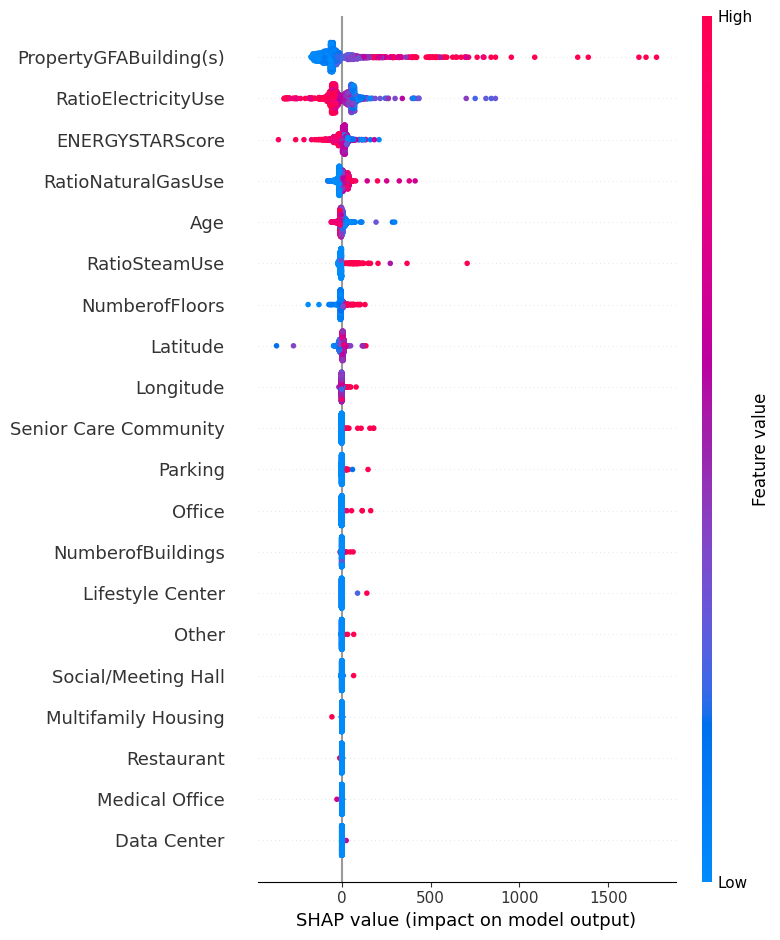

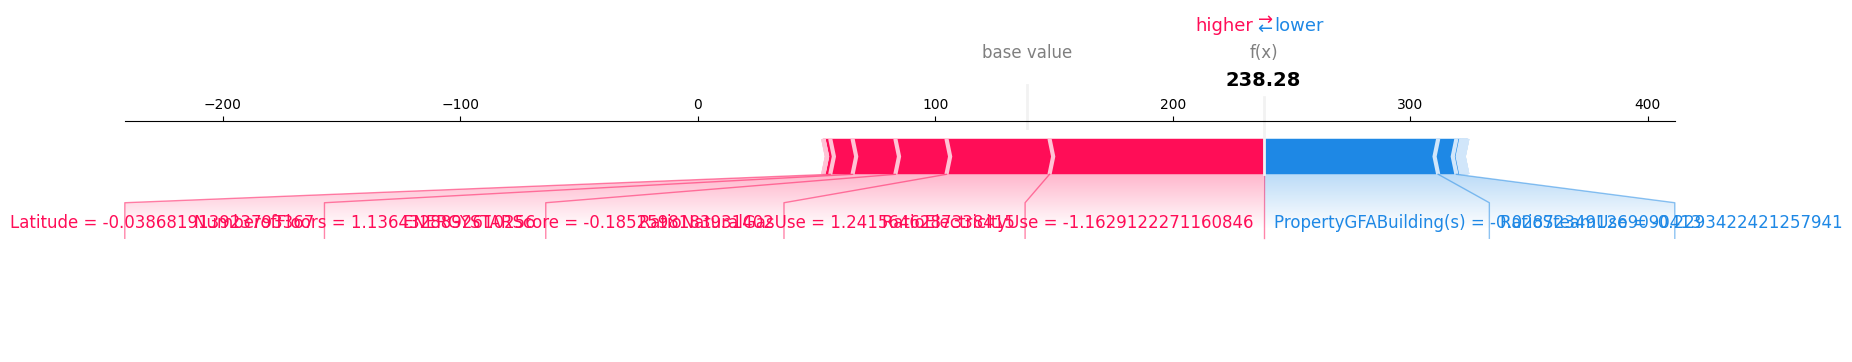

Epoch Progress: 100%|██████████| 30/30 [02:24<00:00,  4.80s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-13139200670401772144260418633728.000000,0.246637,0.210994,0.015645,0.559147,0.559682,324.668469,28.633910,126.816513,0.773684,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.29224828517525836, 'learning_rate'...",0.027339,0.227078,0.250161,0.258643,17.599752,8.427879
1,-2986197509139502943837960011776.000000,0.367611,0.235781,0.120204,0.618686,0.633365,144.185827,53.862761,10.132210,0.425291,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.6714712913976545, 'learning_rate':...",0.107822,0.289998,0.300009,0.462587,18.439774,6.763031
2,0.333658,0.358344,0.285634,0.024341,0.610959,0.718408,150.258899,43.783217,69.361152,0.818799,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.021509283000636037, 'learning_rate...",0.069872,0.293930,0.264144,0.270968,17.629255,6.802361
3,-17350273630904375355037185998848.000000,0.323440,0.321865,0.004072,0.533027,0.545949,100.947027,14.624757,133.670754,0.709939,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.19965891680285597, 'learning_rate'...",0.132873,0.309577,0.271834,0.286686,18.398388,6.907601
4,0.334115,0.283411,0.364397,0.320164,0.776173,0.831658,700.014566,21.228625,4.206245,0.903646,"{'max_depth': 10, 'min_samples_leaf': 2, 'min_...","{'alpha': 0.6607296709854159, 'learning_rate':...",0.067142,0.328975,0.290475,0.291666,17.657604,7.223104


In [34]:
import time

df = Data(data_energystar, 0)

res_2 = pd.DataFrame(df.run())
res_2.head()

              index         0
0         linear R2 -0.466445
1          ridge R2  0.315888
2          lasso R2  0.283734
3        elastic R2  0.096885
4  random forest R2  0.619598
5        xgboost R2  0.657813


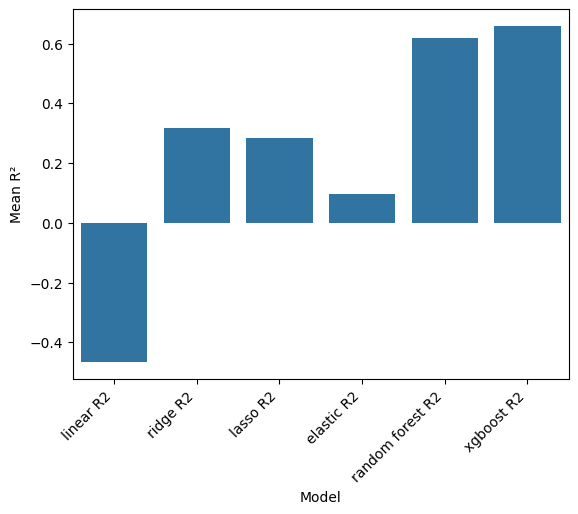

In [35]:
show_result(res_2)

                index         0
0         linear time  0.081009
1          ridge time  0.289912
2          lasso time  0.275324
3        elastic time  0.314110
4  random forest time 17.944955
5        xgboost time  7.224795


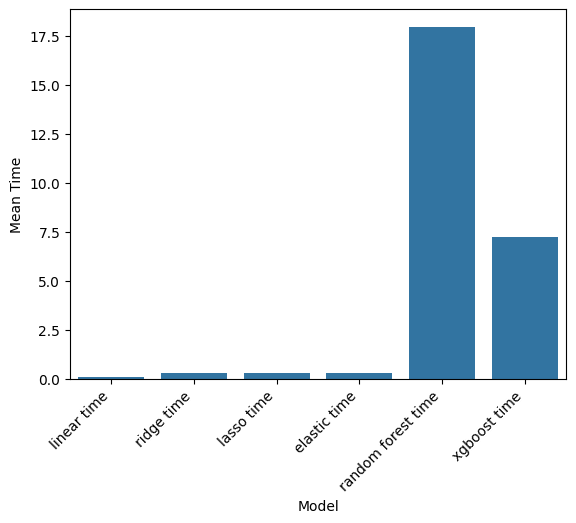

In [36]:
show_time(res_2)